# Gene subset phase and amplitude

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial

# parameters
genome = 'GRCm38'
bin_size = 10_000

phase_path = f'../results/{genome}/phase_amp'
T = np.arange(0,48,4)
Strands = ['forward', 'reverse']
strand_dict = {'forward':'+', 'reverse':'-', '+':'forward', '-':'reverse'}
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY','chrM']

n = 1
P = 24
N = len(T)

# load gene phase and amplitude table
gene_phase_amp = pd.read_csv(f'{phase_path}/gene_phase_amp.csv', sep='\t')
gene_phase_amp.loc[:,'length'] = gene_phase_amp.end - gene_phase_amp.start

thresholds = {'amplitude':0, 'length':10000, 'mean_log_expression':6}

idx = (gene_phase_amp.amplitude > thresholds['amplitude']) & (gene_phase_amp.length > thresholds['length']) & (gene_phase_amp.mean_log_expression > thresholds['mean_log_expression'])

gene_phase_amp = gene_phase_amp[idx].reset_index(drop=True)


# load continuous-time extended kalman filter results
infile = '../results/GRCm38/kalman/extended_kalman_on_expressed_regions_bin10000bp.csv'
kf = pd.read_csv(infile, sep='\t')

def get_average_LL_kf_in_coord(coord):
    idx = (kf.chr == coord[0]) & (kf.start >= coord[1]) & (kf.end <= coord[2]) & (kf.strand == coord[3])
    return kf[idx].LL.mean()

COORD = gene_phase_amp[['chr','start','end','strand']].values
COORD[:,1] = (np.floor(COORD[:,1]/bin_size)*bin_size).astype(int)
COORD[:,2] = (np.ceil(COORD[:,2]/bin_size)*bin_size).astype(int)

threads = 48
with Pool(processes=threads) as pool:
    OUT = pool.map(get_average_LL_kf_in_coord ,COORD)

gene_phase_amp.loc[:,'LL'] = OUT




In [15]:
gene_phase_amp

,chr,start,end,strand,phase,amplitude,R2,pval,mean_log_expression,mean_count_per_bp,gene_name,gene_id,length,LL
0,chr1,3205901,3671498,-,5.301513,0.459664,0.132284,0.528081,7.679662,0.005500,Xkr4,ENSMUSG00000051951.5,465597,NaN
1,chr1,4773206,4785739,-,3.706078,0.175921,0.264366,0.251176,13.381477,10.252379,Mrpl15,ENSMUSG00000033845.13,12533,NaN
2,chr1,4807788,4848410,+,3.285112,0.111360,0.360041,0.134179,14.337746,6.122624,Lypla1,ENSMUSG00000025903.14,40622,NaN
3,chr1,4807892,4886770,+,3.376453,0.078608,0.196398,0.373840,15.298242,6.135511,Gm37988,ENSMUSG00000104217.1,78878,NaN
4,chr1,4857814,4897909,+,5.132663,0.149160,0.238249,0.293872,13.448632,3.354963,Tcea1,ENSMUSG00000033813.15,40095,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11916,chrX,169685199,170005736,+,5.329536,0.376293,0.257625,0.261700,13.132783,0.341583,Mid1,ENSMUSG00000035299.16,320537,NaN
11917,chrY,897788,956786,+,0.231804,0.305622,0.602245,0.015786,13.689220,2.699042,Kdm5d,ENSMUSG00000056673.14,58998,NaN
11918,chrY,1010543,1028847,+,3.319180,0.133127,0.082652,0.678271,12.441116,3.667855,Eif2s3y,ENSMUSG00000069049.11,18304,NaN
11919,chrY,1096861,1245759,-,6.207584,0.228083,0.690199,0.005127,15.287547,3.230612,Uty,ENSMUSG00000068457.14,148898,NaN


Text(0, 0.5, '$LL_{kf}$')

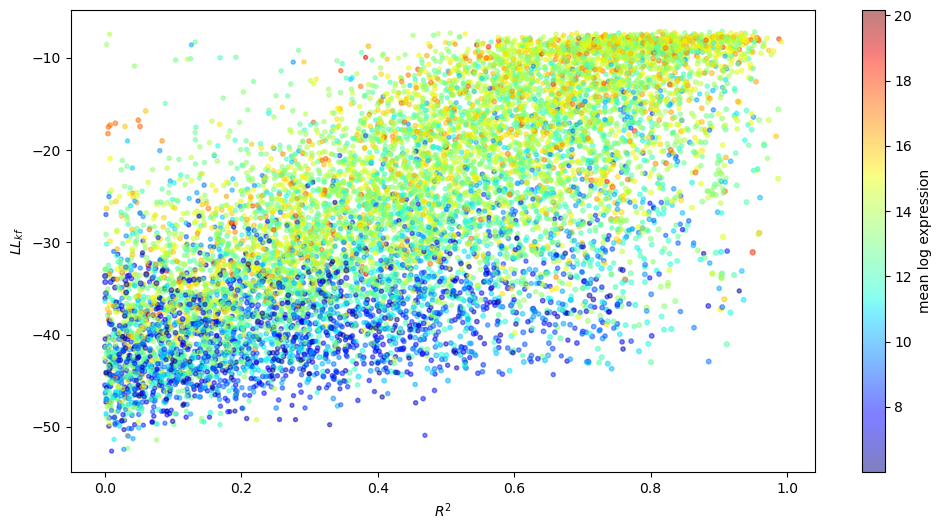

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
h = ax.scatter(gene_phase_amp.R2, gene_phase_amp.LL, c=gene_phase_amp.mean_log_expression, s=np.log10(gene_phase_amp.length)*2, cmap='jet',alpha=0.5)
h = plt.colorbar(h)
h.set_label('mean log expression')

ax.set_xlabel(r'$R^2$')
ax.set_ylabel(r'$LL_{kf}$')

In [82]:
gene_phase_amp

,chr,start,end,strand,phase,amplitude,R2,pval,mean_log_expression,mean_count_per_bp,gene_name,gene_id,length,LL
0,chr1,3205901,3671498,-,5.301513,0.459664,0.132284,0.528081,7.679662,0.005500,Xkr4,ENSMUSG00000051951.5,465597,NaN
1,chr1,3999557,4409241,-,5.521705,0.704039,0.065070,0.738763,3.903946,0.000508,Rp1,ENSMUSG00000025900.12,409684,NaN
2,chr1,4490931,4497354,-,5.732836,0.489007,0.681956,0.005770,10.247113,2.292365,Sox17,ENSMUSG00000025902.13,6423,NaN
3,chr1,4773206,4785739,-,3.706078,0.175921,0.264366,0.251176,13.381477,10.252379,Mrpl15,ENSMUSG00000033845.13,12533,NaN
4,chr1,4807788,4848410,+,3.285112,0.111360,0.360041,0.134179,14.337746,6.122624,Lypla1,ENSMUSG00000025903.14,40622,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21844,chrM,9877,10173,+,6.153134,0.126374,0.005347,0.976161,6.376262,3.638398,mt-Nd4l,ENSMUSG00000065947.3,296,NaN
21845,chrM,10167,11544,+,5.751213,1.157691,0.829271,0.000351,11.371123,24.219306,mt-Nd4,ENSMUSG00000064363.1,1377,NaN
21846,chrM,11742,13565,+,5.988766,0.693489,0.785627,0.000978,13.571372,81.635359,mt-Nd5,ENSMUSG00000064367.1,1823,NaN
21847,chrM,13552,14070,-,5.978044,0.215073,0.207219,0.351713,15.260259,915.309316,mt-Nd6,ENSMUSG00000064368.1,518,NaN
